# Preparation

In [1]:
import pandas as pd
%pylab inline

# date handling
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')

Populating the interactive namespace from numpy and matplotlib


# Load Data

In [6]:
# Newsletter
newsl = pd.read_csv('../data/Newsletter.CSV', parse_dates = ['Abmeldedatum','Anmeldedatum'],date_parser = dateparse)
# Info on cancellation
abo_canc = pd.read_csv("../data/SSOID_CancDatum.CSV", encoding = 'latin-1', date_parser = dateparse, parse_dates=["K Tag"])
# Main infos on subscriptions
product_owner = pd.read_csv("../data/SSOID_Produktbesitze.CSV", encoding = 'latin-1', 
                            parse_dates = ['VB_Tag','VE_Tag'], date_parser = dateparse)


In [3]:
product_owner.columns.values

array(['KD SSO-ID', 'VT Transaction ID', 'Verkaufsort', 'Vertragsstatus',
       'Kuendigungsstatus', 'Kuendigungsgrund', 'Kuendigungsgrund_ID',
       'Angebotsgruppe', 'Promotion_ID', 'Angebotsname', 'Vertragsform',
       'Trial_Kennzeichen', 'Laufzeit_Trial', 'Laufzeit', 'Vertragsphase',
       'VB_Tag', 'VE_Tag', 'Lieferdauer'], dtype=object)

In [3]:
print(product_owner.columns.values)
print('')
print(abo_canc.columns.values)
print('')
print(newsl.columns.values)

['KD SSO-ID' 'VT Transaction ID' 'Verkaufsort' 'Vertragsstatus'
 'Kuendigungsstatus' 'Kuendigungsgrund' 'Kuendigungsgrund_ID'
 'Angebotsgruppe' 'Promotion_ID' 'Angebotsname' 'Vertragsform'
 'Trial_Kennzeichen' 'Laufzeit_Trial' 'Laufzeit' 'Vertragsphase' 'VB_Tag'
 'VE_Tag' 'Lieferdauer']

['KD SSO-ID' 'VT Transaction ID' 'AN Promotion ID' 'K Tag'
 'VT Kündigungsgrund']

['SSO ID' 'Abmeldedatum' 'Anmeldedatum' 'Newsletter mit Klartext']


### Some Merging & data filtering

In [7]:
# merge product_owner with subscription cancellation by SSO-ID, VT Transcactions-ID to get date of cancellation
# some duplicates
product_owner_canc = pd.merge(product_owner, abo_canc, on=['KD SSO-ID', 'VT Transaction ID'])
product_owner_canc = product_owner_canc.drop_duplicates(['KD SSO-ID', 'VT Transaction ID'], keep='last')

# long subsriptions (WeltPlus, WeltPremium, WeltGold ) + Vollabo
po_longSubs = product_owner.loc[((product_owner['Promotion_ID'] == 10003002) & (product_owner['Vertragsphase'] == 'Vollabo'))|
                           ((product_owner['Promotion_ID'] == 10003006) & (product_owner['Vertragsphase'] == 'Vollabo'))|
                           ((product_owner['Promotion_ID'] == 10003011) & (product_owner['Vertragsphase'] == 'Vollabo'))].copy()

# long subsriptions (WeltPlus, WeltPremium, WeltGold ) + Vollabo + Kündigungsdatum
po_longSubs_canc = product_owner_canc.loc[((product_owner_canc['Promotion_ID'] == 10003002) & (product_owner_canc['Vertragsphase'] == 'Vollabo'))|
                           ((product_owner_canc['Promotion_ID'] == 10003006) & (product_owner_canc['Vertragsphase'] == 'Vollabo'))|
                           ((product_owner_canc['Promotion_ID'] == 10003011) & (product_owner_canc['Vertragsphase'] == 'Vollabo'))].copy()

po_longSubs_canc['Vertragslaenge'] =  (po_longSubs_canc['VE_Tag'] - po_longSubs_canc['VB_Tag']) / np.timedelta64(1, 'D')

### Untergruppen für Vertragslängen

count    7749.000000
mean       97.603691
std        69.924465
min        28.000000
25%        58.000000
50%        61.000000
75%       121.000000
max       456.000000
Name: Vertragslaenge, dtype: float64


[Text(0,0.5,'Anzahl der Abos'), Text(0.5,0,'Länge der Abos in Tagen')]

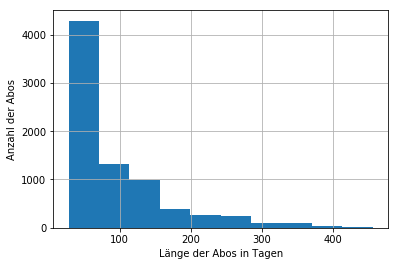

In [5]:
print(po_longSubs_canc['Vertragslaenge'].describe())
pt = po_longSubs_canc['Vertragslaenge'].hist()
pt.set(xlabel='Länge der Abos in Tagen',
       ylabel='Anzahl der Abos')

In [6]:
print('Prozent der langfristigen Abos mit Laufzeit von bis zu 1 Monaten:')
print('%2.2f'%(sum(po_longSubs_canc['Vertragslaenge']<=31)/7749*100)+'%')
print()
print('Prozent der langfristigen Abos mit Laufzeit von bis zu 2 Monaten:')
print('%2.2f'%(sum(po_longSubs_canc['Vertragslaenge']<=62)/7749*100)+'%')
print()
print('Prozent der langfristigen Abos mit Laufzeit von bis zu 3 Monaten:')
print('%2.2f'%(sum(po_longSubs_canc['Vertragslaenge']<=92)/7749*100)+'%')
print()
print('Prozent der langfristigen Abos mit Laufzeit von bis zu 4 Monaten:')
print('%2.2f'%(sum(po_longSubs_canc['Vertragslaenge']<=124)/7749*100)+'%')
print()
print('Prozent der langfristigen Abos mit Laufzeit von bis zu 5 Monaten:')
print('%2.2f'%(sum(po_longSubs_canc['Vertragslaenge']<=155)/7749*100)+'%')
print()
print('Prozent der langfristigen Abos mit Laufzeit von bis zu 6 Monaten:')
print('%2.2f'%(sum(po_longSubs_canc['Vertragslaenge']<=186)/7749*100)+'%')

Prozent der langfristigen Abos mit Laufzeit von bis zu 1 Monaten:
0.50%

Prozent der langfristigen Abos mit Laufzeit von bis zu 2 Monaten:
53.88%

Prozent der langfristigen Abos mit Laufzeit von bis zu 3 Monaten:
70.05%

Prozent der langfristigen Abos mit Laufzeit von bis zu 4 Monaten:
79.31%

Prozent der langfristigen Abos mit Laufzeit von bis zu 5 Monaten:
85.25%

Prozent der langfristigen Abos mit Laufzeit von bis zu 6 Monaten:
89.59%


In [8]:
# make column which labels different contract lengths
# Gruppe 1: Vertragslänge 2 Monate (~ 54%)
# Gruppe 2: Vertragslänge 4 Monate (~ 25%)
# Gruppe 3: Vertragslänge > 4 Monate (~ 21%)
po_longSubs_canc['Vertragslaenge_Gruppe'] = "Gr3"
po_longSubs_canc.loc[po_longSubs_canc['Vertragslaenge'] <= 124, 'Vertragslaenge_Gruppe' ] ="Gr2"
po_longSubs_canc.loc[po_longSubs_canc['Vertragslaenge'] <= 62, 'Vertragslaenge_Gruppe' ] ="Gr1"

# Data Exploration
## Ziel: Kann man Gründe für die Kündigung erkennen?

## Subscriptions

Zeitraum der Abschlüsse:

In [9]:
print('Erstes Abschlussdatum: ', product_owner['VB_Tag'].min() )
print('Letztes Abschlussdatum: ', product_owner['VB_Tag'].max() )

Erstes Abschlussdatum:  2017-01-01 00:00:00
Letztes Abschlussdatum:  2018-04-10 00:00:00


Wieviele Abos haben die Nutzer? WER SCHREIBEN GANZ VIEL

In [10]:
product_owner['KD SSO-ID'].value_counts().describe()

count    79614.000000
mean         1.259050
std          1.795813
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         92.000000
Name: KD SSO-ID, dtype: float64

Text(0,0.5,'Anzahl der Abos')

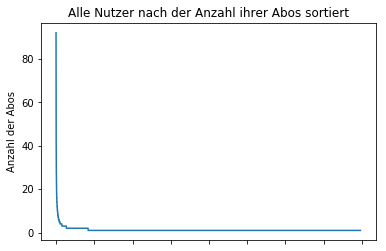

In [60]:
pt = product_owner['KD SSO-ID'].value_counts().plot(title = 'Alle Nutzer nach der Anzahl ihrer Abos sortiert')
pt.set_ylabel('Anzahl der Abos')

Die ersten 20 Nutzer mit den meisten Abos und der Anzahl ihrer Abos:

In [61]:
product_owner['KD SSO-ID'].value_counts().head(20)

ASAG7600228    92
ASAG7557870    85
ASAG7745914    77
ASAG7497519    72
ASAG7742859    70
ASAG7545899    69
ASAG7769987    65
ASAG7473365    64
ASAG7813225    62
ASAG2935534    61
ASAG6906902    59
ASAG7692401    57
ASAG7624703    56
ASAG7798826    56
ASAG7490157    53
ASAG2736896    52
ASAG7842014    52
ASAG1832843    51
ASAG7501477    51
ASAG7503656    51
Name: KD SSO-ID, dtype: int64

Die allermeisten Nutzer besitzen nur ein Abo, einige wenige mehrere Abos.

In [123]:
products_howoften = product_owner['Promotion_ID'].value_counts().to_frame()
products_howoften.columns = ['Anzahl']
products_howoften = products_howoften.assign( 
    Prozent_von_allen_Abos = product_owner['Promotion_ID'].value_counts()/product_owner.shape[0] )
products_howoften.head(10)

,Anzahl,Prozent_von_allen_Abos
10003055,23910,0.238532
10003002,23467,0.234113
10003111,17600,0.175582
10003112,9931,0.099074
10003145,4056,0.040464
10003006,3849,0.038399
10003011,2518,0.025120
10003131,2165,0.021599
10003056,911,0.009088
10003136,854,0.008520


Known promotion IDs: 
    - 10003002 - WeltPlus
    - 10003006 - WeltPremium
    - 10003011 - WeltGold

In [118]:
products_howoften.loc[[10003002,10003006,10003011]]

,Anzahl,Prozent_von_allen_Abos
10003002,23467,0.234113
10003006,3849,0.038399
10003011,2518,0.025120


Weltplus spielt mit einem Anteil von 23% allen abgeschlossenen Abos eine große Rolle und liegt damit an zweiter Stelle, fast gleich auf mit der Promotion ID 10003055. WeltPremium hat einen Anteil von ca. 4% und WeltGold einen Anteil von 2.5% von allen Abos, werden also vergleichsweise wenig gebucht.

## Kündigungsstatus

In [11]:
product_owner.groupby('Kuendigungsstatus').count()['KD SSO-ID']

Kuendigungsstatus
gekuendigt      25985
ungekuendigt    74253
Name: KD SSO-ID, dtype: int64

In [12]:
# Cancelled subscriptions ordered by Promotion_ID and occurence
test=product_owner[product_owner['Kuendigungsstatus']== 
                   'gekuendigt'].groupby('Promotion_ID').count()['KD SSO-ID'].sort_values(ascending = False)
test.head(10)

Promotion_ID
10003002    13749
10003145     2817
10003006     2692
10003011     1902
10003136      833
10003137      457
10003069      307
10003183      274
10003098      252
10003111      251
Name: KD SSO-ID, dtype: int64

Die häufigsten Kündigungen gibt es bei WeltPlus.

In [13]:
kund = product_owner[product_owner['Promotion_ID']==10003002].groupby('Kuendigungsstatus').count()['KD SSO-ID']
print('Kuendingungsstatus bei WeltPlus')
print(kund)
print('gekündigt (prozentual von allen WeltPlus-Abos)= ', kund[0]/(kund[0]+kund[1]))
print('')
kund = product_owner[product_owner['Promotion_ID']==10003006].groupby('Kuendigungsstatus').count()['KD SSO-ID']
print('Kuendingungsstatus bei WeltPremium')
print(kund)
print('gekündigt (prozentual von allen WeltPremium-Abos)= ', kund[0]/(kund[0]+kund[1]))
print('')
kund = product_owner[product_owner['Promotion_ID']==10003011].groupby('Kuendigungsstatus').count()['KD SSO-ID']
print('Kuendingungsstatus bei WeltGold')
print(kund)
print('gekündigt (prozentual von allen WeltGold-Abos)= ', kund[0]/(kund[0]+kund[1]))

Kuendingungsstatus bei WeltPlus
Kuendigungsstatus
gekuendigt      13749
ungekuendigt     9718
Name: KD SSO-ID, dtype: int64
gekündigt (prozentual von allen WeltPlus-Abos)=  0.5858865641113052

Kuendingungsstatus bei WeltPremium
Kuendigungsstatus
gekuendigt      2692
ungekuendigt    1157
Name: KD SSO-ID, dtype: int64
gekündigt (prozentual von allen WeltPremium-Abos)=  0.6994024421927774

Kuendingungsstatus bei WeltGold
Kuendigungsstatus
gekuendigt      1902
ungekuendigt     616
Name: KD SSO-ID, dtype: int64
gekündigt (prozentual von allen WeltGold-Abos)=  0.7553613979348689


Obwohl WeltPlus absolut die häufigsten Kündigungen erfährt, ist die **Kündigungsrate** für die höher preisigen Abos höher.

## Kündigungsgründe

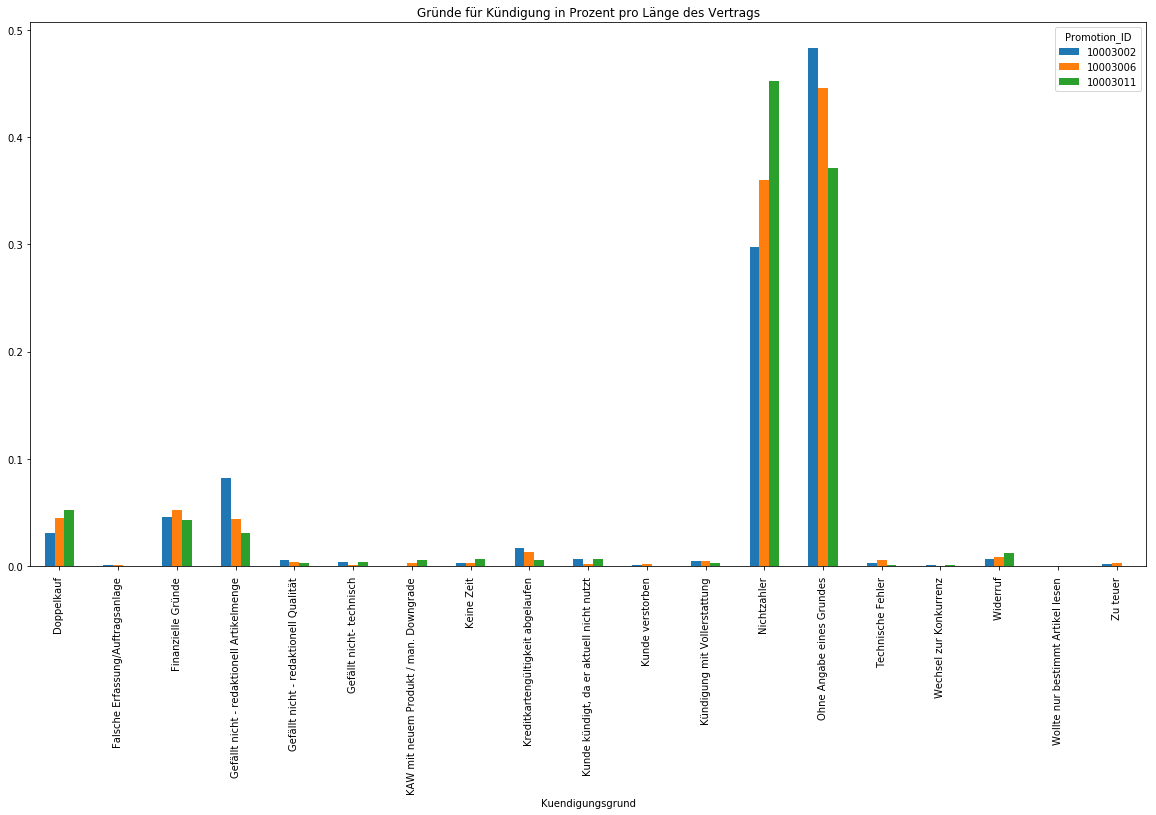

In [10]:
po_longSubs_cancReas_count = po_longSubs_canc.groupby(['Kuendigungsgrund','Promotion_ID'])['KD SSO-ID'].count()
po_longSubs_promo = po_longSubs_canc.groupby('Promotion_ID')['KD SSO-ID'].count()
po_longSubs_cancReas_perc = po_longSubs_cancReas_count.div(po_longSubs_promo, level='Promotion_ID')

po_longSubs_cancReas_perc.unstack().plot(kind='bar', figsize=(20,10), title= "Gründe für Kündigung in Prozent pro Länge des Vertrags")

Sehr ähnliche Verteilung der Kündigungsgründe bei den verschiedenen Abos. Ein wenig mehr bei WeltPlus - "Gefällt nicht", wenig mehr bei "Nichtzahler" bei den höherpreisigen Abos.

In [15]:
print(' Absolute Anzahl der obigen Darstellung')
po_longSubs.groupby(['Promotion_ID','Kuendigungsgrund']).count()['KD SSO-ID']


 Absolute Anzahl der obigen Darstellung


Promotion_ID  Kuendigungsgrund                          
10003002      Doppelkauf                                     176
              Falsche Erfassung/Auftragsanlage                 6
              Finanzielle Gründe                             265
              Gefällt nicht - redaktionell Artikelmenge      475
              Gefällt nicht - redaktionell Qualität           33
              Gefällt nicht- technisch                        20
              KAW mit neuem Produkt / man. Downgrade           2
              Keine Zeit                                      17
              Kreditkartengültigkeit abgelaufen               97
              Kunde kündigt, da er aktuell nicht nutzt        40
              Kunde verstorben                                 5
              Kündigung mit Vollerstattung                    27
              Nichtzahler                                   1726
              Ohne Angabe eines Grundes                     2801
              Technische Fehler  

In [5]:
po_longSubs_cancReas_count = po_longSubs_canc.groupby(['Kuendigungsgrund','Vertragslaenge_Gruppe'])['KD SSO-ID'].count()
po_longSubs_promo = po_longSubs_canc.groupby('Vertragslaenge_Gruppe')['KD SSO-ID'].count()
po_longSubs_cancReas_perc = po_longSubs_cancReas_count.div(po_longSubs_promo, level='Vertragslaenge_Gruppe')

po_longSubs_cancReas_perc.unstack().plot(kind='bar', figsize=(20,10), title= "Gründe für Kündigung in Prozent pro Länge des Vertrags")

NameError: name 'po_longSubs_canc' is not defined

Ein Großteil der Abos werden nach 2 Monaten gekündigt mit dem Grund "Nichtzahler". Falsche Zahlungsdetails hinterlegt? 

Bei langfristigen Abos laufen die Kreditkarten ab.

In [17]:
print("Absolute Anzahl der obigen Darstellung")
po_longSubs_canc.groupby(['Vertragslaenge_Gruppe','Kuendigungsgrund']).count()['KD SSO-ID']

Absolute Anzahl der obigen Darstellung


Vertragslaenge_Gruppe  Kuendigungsgrund                          
Gr1                    Doppelkauf                                     136
                       Falsche Erfassung/Auftragsanlage                 4
                       Finanzielle Gründe                             191
                       Gefällt nicht - redaktionell Artikelmenge      308
                       Gefällt nicht - redaktionell Qualität           19
                       Gefällt nicht- technisch                        13
                       KAW mit neuem Produkt / man. Downgrade           2
                       Keine Zeit                                      12
                       Kreditkartengültigkeit abgelaufen               14
                       Kunde kündigt, da er aktuell nicht nutzt        26
                       Kündigung mit Vollerstattung                     7
                       Nichtzahler                                   1528
                       Ohne Angabe eines Grund

## Kündigungstag + Product_owner

In [18]:
product_owner.shape

(100238, 18)

In [19]:
product_owner[product_owner['Kuendigungsstatus']=='gekuendigt'].shape

(25985, 18)

In [20]:
# merge product_owner with subscription cancellation by SSO-ID, VT Transcactions-ID to get date of cancellatioon
product_owner_canc = pd.merge(product_owner, abo_canc, on=['KD SSO-ID', 'VT Transaction ID'])
product_owner_canc.shape

(26164, 21)

**TOASK:** 

Manche (105) VT Transaction ID+SSO-ID haben 2 (oder mehr) Kündigungsdaten? Unten stehen Beispiele.

In [21]:
product_owner_canc[product_owner_canc.duplicated(['KD SSO-ID', 'VT Transaction ID'])].shape
# subscription with 2 K Tag
product_owner_canc[product_owner_canc['KD SSO-ID'] == 'ASAG1653447']

,KD SSO-ID,VT Transaction ID,Verkaufsort,Vertragsstatus,Kuendigungsstatus,Kuendigungsgrund,Kuendigungsgrund_ID,Angebotsgruppe,Promotion_ID,Angebotsname,...,Trial_Kennzeichen,Laufzeit_Trial,Laufzeit,Vertragsphase,VB_Tag,VE_Tag,Lieferdauer,AN Promotion ID,K Tag,VT Kündigungsgrund
36,ASAG1653447,aa1d80a7ba424584b734840eea463bb2,WONP,nicht aktiv,gekuendigt,Widerruf,6.0,WELTplus Premium,10003007,wb.pluspremium.1m.0.0.nop.b2c.-.-,...,ohne Trial,NaN,1.0,Vollabo,2017-01-08,2018-01-08,365,10003007,2017-07-20,Widerruf
37,ASAG1653447,aa1d80a7ba424584b734840eea463bb2,WONP,nicht aktiv,gekuendigt,Widerruf,6.0,WELTplus Premium,10003007,wb.pluspremium.1m.0.0.nop.b2c.-.-,...,ohne Trial,NaN,1.0,Vollabo,2017-01-08,2018-01-08,365,10003031,2017-07-09,Kündigung Print-Abo / Upselling


In [22]:
product_owner_canc[product_owner_canc['KD SSO-ID'] == 'ASAG8467292']

,KD SSO-ID,VT Transaction ID,Verkaufsort,Vertragsstatus,Kuendigungsstatus,Kuendigungsgrund,Kuendigungsgrund_ID,Angebotsgruppe,Promotion_ID,Angebotsname,...,Trial_Kennzeichen,Laufzeit_Trial,Laufzeit,Vertragsphase,VB_Tag,VE_Tag,Lieferdauer,AN Promotion ID,K Tag,VT Kündigungsgrund
20799,ASAG8467292,315ec0853ab04cbdb572696276c30bc9,WONP,nicht aktiv,gekuendigt,Ohne Angabe eines Grundes,0.0,WELTplus,10003002,wb.plus.1m.1m.0.nop.b2c.-.-,...,kostenloser Trial,1.0,1.0,Vollabo,2017-11-21,2018-01-20,60,10003002,2018-01-10,~
20800,ASAG8467292,315ec0853ab04cbdb572696276c30bc9,WONP,nicht aktiv,gekuendigt,Ohne Angabe eines Grundes,0.0,WELTplus,10003002,wb.plus.1m.1m.0.nop.b2c.-.-,...,kostenloser Trial,1.0,1.0,Vollabo,2017-11-21,2018-01-20,60,10003002,2018-01-20,Ohne Angabe eines Grundes
20801,ASAG8467292,315ec0853ab04cbdb572696276c30bc9,WONP,nicht aktiv,ungekuendigt,NaN,NaN,WELTplus,10003002,wb.plus.1m.1m.0.nop.b2c.-.-,...,kostenloser Trial,1.0,1.0,Vollabo,2017-11-21,2018-01-20,140,10003002,2018-01-10,~
20802,ASAG8467292,315ec0853ab04cbdb572696276c30bc9,WONP,nicht aktiv,ungekuendigt,NaN,NaN,WELTplus,10003002,wb.plus.1m.1m.0.nop.b2c.-.-,...,kostenloser Trial,1.0,1.0,Vollabo,2017-11-21,2018-01-20,140,10003002,2018-01-20,Ohne Angabe eines Grundes


In [23]:
product_owner_canc[product_owner_canc['KD SSO-ID'] == 'ASAG7850824']

,KD SSO-ID,VT Transaction ID,Verkaufsort,Vertragsstatus,Kuendigungsstatus,Kuendigungsgrund,Kuendigungsgrund_ID,Angebotsgruppe,Promotion_ID,Angebotsname,...,Trial_Kennzeichen,Laufzeit_Trial,Laufzeit,Vertragsphase,VB_Tag,VE_Tag,Lieferdauer,AN Promotion ID,K Tag,VT Kündigungsgrund
11242,ASAG7850824,d4cfecd88bea4b3aa3c790ee380b889c,WONP,aktiv,ungekuendigt,NaN,NaN,WELTplus Premium,10003024,wb.pluspremium.1m.0.0.nop.b2c.up.-,...,ohne Trial,NaN,1.0,Vollabo,2017-03-15,2018-04-29,391,10003007,2017-10-23,Doppelkauf
11243,ASAG7850824,d4cfecd88bea4b3aa3c790ee380b889c,WONP,aktiv,ungekuendigt,NaN,NaN,WELTplus Premium,10003024,wb.pluspremium.1m.0.0.nop.b2c.up.-,...,ohne Trial,NaN,1.0,Vollabo,2017-03-15,2018-04-29,391,10003024,2017-08-14,Kündigung Print-Abo / Upselling
11244,ASAG7850824,d4cfecd88bea4b3aa3c790ee380b889c,WONP,aktiv,ungekuendigt,NaN,NaN,WELTplus Premium,10003024,wb.pluspremium.1m.0.0.nop.b2c.up.-,...,ohne Trial,NaN,1.0,Vollabo,2017-03-15,2018-04-29,391,10003024,2017-09-05,Widerruf


In [22]:
test = product_owner_canc.groupby(['KD SSO-ID', 'VT Transaction ID']).count()['Kuendigungsstatus']
test[test>2]

KD SSO-ID    VT Transaction ID               
ASAG7129021  f64b11d2b62b41d58757186e08ec85f4    3
ASAG7850824  d4cfecd88bea4b3aa3c790ee380b889c    3
ASAG8467292  315ec0853ab04cbdb572696276c30bc9    4
ASAG8467966  ed849c7f80c74ef7bc01ad9157be63d3    4
ASAG8469316  42b819ece4464146b287f3c3d0635aab    4
Name: Kuendigungsstatus, dtype: int64

## Newsletter

Fällt Kündigungsdatum mit Newsletterabbestellung zusammen? Gucken wir uns doch mal den Zeitabstand zwischen letzter Newsletter-Abbestellung und Kündigunsdatum an.

In [68]:
# find date of last newsletter cancellation
newsl_canc = newsl.groupby('SSO ID')['Abmeldedatum'].agg('max').to_frame()
first_newsl_canc = newsl.groupby('SSO ID')['Abmeldedatum'].agg('min').to_frame()
newsl_canc = pd.merge(first_newsl_canc, newsl_canc, right_index=True, left_index=True)
newsl_canc.columns = ['first_newsl_canc_date','last_newsl_canc_date']
newsl_canc['KD SSO-ID'] = newsl_canc.index
#newsl_canc.head()

In [69]:
# merge product_owner with last newsletter cancellation on SSO-ID = product owner with newsletter subscription
product_owner_w_newsl = pd.merge(product_owner_canc, newsl_canc, on = 'KD SSO-ID')
product_owner_w_newsl.shape

(476, 23)

Product owner mit Newsletter cancellation sind DEUTLICH weniger Kunden. Es gibt nur 479 Abonenten (unabhängig welches Abo) mit Newsletter-Kündigung.

[Text(0.5,0,'Tag_Abokündigung - Tag_Newsletterkündigung in Tagen')]

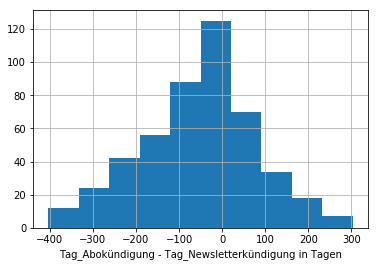

In [70]:
# time difference between last newsletter cancellation and subscription cancellation?
product_owner_w_newsl['diff_canc_subs_and_newsl'] = \
(product_owner_w_newsl['K Tag'] - product_owner_w_newsl['last_newsl_canc_date']) / np.timedelta64(1, 'D')
pt = product_owner_w_newsl['diff_canc_subs_and_newsl'].hist()
pt.set(xlabel="Tag_Abokündigung - Tag_Newsletterkündigung in Tagen")

[Text(0.5,0,"Tag_Abokündigung - Tag_Newsletterkündigung in Tagen \n mit Vertragsstatus 'Vollabo'"),
 Text(0.5,1,'Nur WeltPlus, WeltPremium, WeltGold')]

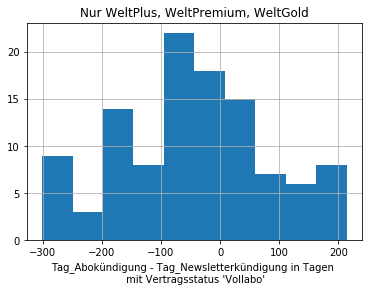

In [71]:
pt_df = product_owner_w_newsl[((product_owner_w_newsl['Promotion_ID']==10003002) & (product_owner_w_newsl['Vertragsphase']=='Vollabo')) | 
                           ((product_owner_w_newsl['Promotion_ID']==10003006) & (product_owner_w_newsl['Vertragsphase']=='Vollabo')) | 
                           ((product_owner_w_newsl['Promotion_ID']==10003011) & (product_owner_w_newsl['Vertragsphase']=='Vollabo'))  ]['diff_canc_subs_and_newsl']
pt = pt_df.hist()
pt.set(title = 'Nur WeltPlus, WeltPremium, WeltGold', xlabel="Tag_Abokündigung - Tag_Newsletterkündigung in Tagen \n mit Vertragsstatus 'Vollabo'")

In [72]:
pt_df.shape

(110,)

Tatsächlich werden Newsletter oft im Zeitraum der Abo-Kündigung gekündigt, eher jedoch kurz **nach** der Abo-Kündigung (negative Zahlen). Zudem ist die Verteilung sehr groß und nur wenige Abo-Inhaber mit VollAbo (110) haben überhaupt einen Newsletter abonniert. Damit ist die Newsletter-Küdingung kein guter Predictor für Abo-Kündigung.

## Wie lang nutzen Kunden Abos?

Es gibt 3 Zeiträume:
 - Vertragsbeginn - Kündigung (Variablen: VB_Tag, K Tag)
 - Vertragsbeginn - Vertragsende (VB_Tag, VE_Tag)
 - Laufzeit (in Monaten)

In [73]:
product_owner_canc['K_-VA'] = (product_owner_canc['K Tag'] - product_owner_canc['VB_Tag']) / np.timedelta64(1, 'D')
product_owner_canc['VE_-VA'] = (product_owner_canc['VE_Tag'] - product_owner_canc['VB_Tag']) / np.timedelta64(1, 'D')

In [74]:
po_longSubs = product_owner_canc.loc[((product_owner_canc['Promotion_ID']==10003002) & (product_owner_canc['Vertragsphase']=='Vollabo')) | 
                           ((product_owner_canc['Promotion_ID']==10003006) & (product_owner_canc['Vertragsphase']=='Vollabo')) | 
                           ((product_owner_canc['Promotion_ID']==10003011)& (product_owner_canc['Vertragsphase']=='Vollabo')) ].copy()

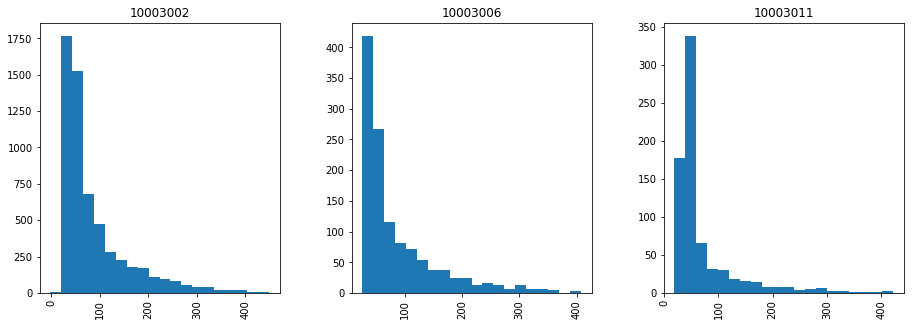

In [75]:
pl = po_longSubs['K_-VA'].hist(by=po_longSubs['Promotion_ID'], layout=(1,3), figsize =(15,5), bins=20)

In [76]:
po_longSubs.groupby('Promotion_ID')['K_-VA'].describe()

,count,mean,std,min,25%,50%,75%,max
Promotion_ID,,,,,,,,
10003002,5793.0,86.171241,71.388290,-2.0,39.0,55.0,105.0,448.0
10003006,1216.0,86.770559,69.615126,26.0,42.0,54.0,108.0,407.0
10003011,740.0,69.950000,59.913257,19.0,40.0,47.0,70.0,421.0


Es scheint keinen eindeutigen Trend zu geben. Es gibt bei Plus und Premium eher Kunden, die das Abo lange haben - im Vergleich zu Gold.

**Alle Abos**

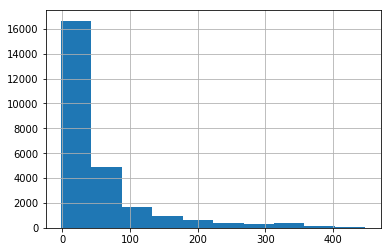

In [77]:
product_owner_canc['K_-VA'].hist()

In [78]:
product_owner_canc['K_-VA'].describe()

count    26059.000000
mean        51.951571
std         73.911850
min         -2.000000
25%          5.000000
50%         24.000000
75%         61.000000
max        448.000000
Name: K_-VA, dtype: float64

## Gibt es viele Kandidaten, die vom teuren auf ein günstigeres Produkt gewechselt sind?

In [79]:
# all SSO-ID with several subscriptions of WeltPlus, WeltPremium and WeltGold
doublelongSub = pd.concat(g for _, g in po_longSubs.groupby('KD SSO-ID')  if len(g) > 1) 
doublelongSub.shape

(766, 23)

In [198]:
# unique SSO-IDs with multiple subscriptions of WeltPlus & Co.
doublelongSub['KD SSO-ID'].unique().shape

(326,)

In [201]:
# unique SSO-IDs with different subscriptions
np.sum(doublelongSub.groupby('KD SSO-ID')['Promotion_ID'].nunique()>1)

75

Es gibt 326 Kunden, die mehr als ein VollAbo haben/hatten. Davon haben aber nur 75 ein Abo unterschiedlicher Art. Es scheint also kein übliches Muster zu sein vom teuren zum günstigeren Abo zu wechseln.